In [45]:
#hide
from utils import *
hc(
    "Acoustic Feature Extraction from Music",
    [""]
)

# Quest

1. How can we measure the local loudness of an audio track?
2. How can we determine the cutoff frequency beyond which a song contains negligible energy?
3. How to compute tempo of a song?
4. How can we quantify the local rhythmicity of a song?

# A Sample Song

In [1]:
#hide
def compute_spec(y, sr, N=1024, H=160, gamma=10):
    """
    Compute log-compressed power spectrogram.

    Parameters
    ----------
    y: ndarray
        - Audio signal.
    sr: float | int
        - Sampling rate of the audio signal.
    gamma: number (> 1)
        - Log compression factor
    """
    import librosa
    
    S = librosa.stft(y, n_fft=N, win_length=N, hop_length=H)
    S = np.log(1 + gamma*(np.abs(S)**2))
    S_f = np.arange(S.shape[0]) * (sr / N)
    S_t = np.arange(S.shape[1]) * (H / sr)

    return S, S_f, S_t

In [68]:
import modusa as ms
import numpy as np
import librosa
import pandas as pd
import pyloudnorm as pyln

audio_fp = "../../../music/songs/Danny, Avvy Sra, Sagar - Ve Haaniyaan.mp3" # Choose a random song
ann = [(60, 80, "1"), (110, 130, "2"), (155, 190, "3"), (215, 235, "4")] # These are manually labelled regions where there is high percussive elements

y, sr, title = ms.load(audio_fp, None)

# Computing the spectrogram
N, H = 1024, 480
S, S_f, S_t = compute_spec(y, sr, N, H, gamma=10)
S_sr = int(sr / H)

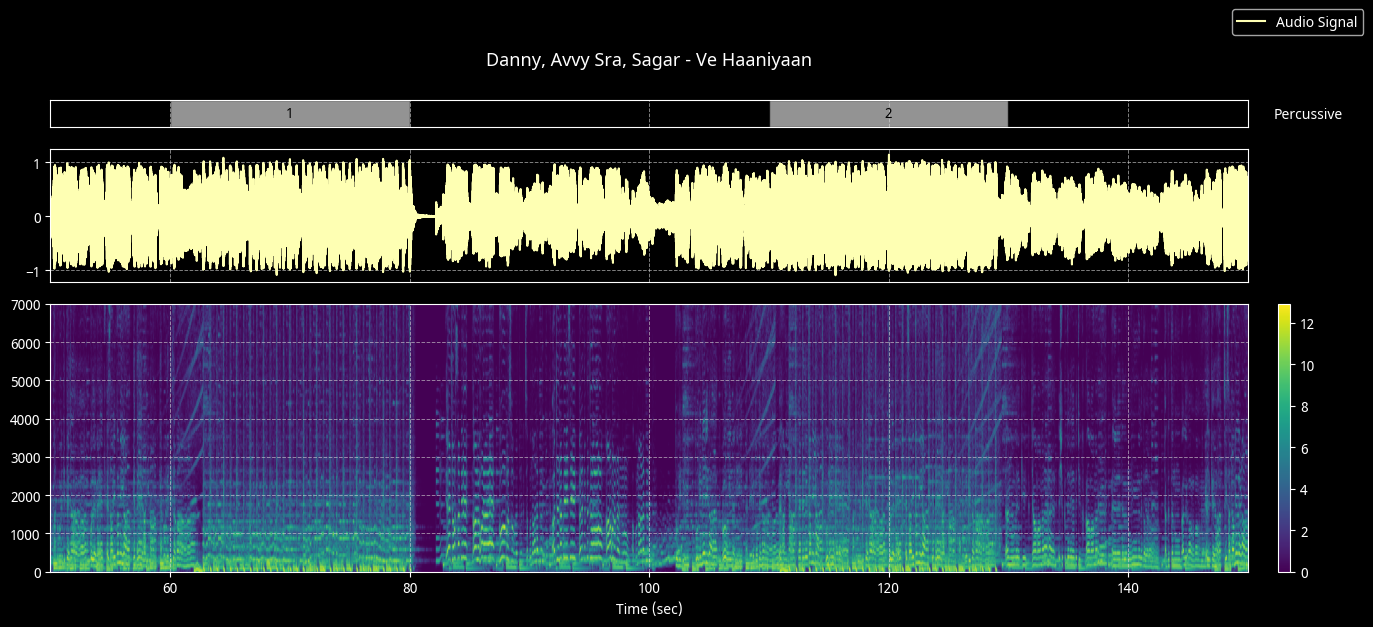

In [7]:
fig = ms.fig("asm", xlim=(50, 150))
fig.add_annotation(ann, label="Percussive")
fig.add_signal(y, np.arange(y.size) / sr, label="Audio Signal")
fig.add_matrix(S, S_f, S_t, o="lower", ylim=(0, 7000))
fig.add_xlabel("Time (sec)")
fig.add_title(title)
fig.add_legend()

# Loudness

We use *pyloudnorm* by Steinmetz, Christian J. and Reiss, Joshua D. that implements ITU-R BS.1770-4 to compute loudness. We make some adjustment to compute the loudness locally.

In [71]:
# Utility Functions
def get_res_setting(res:str=None):
	"""
	Get predefined resolution settings.
    
	Parameters
	----------
	res: str
		LOW or HIGH resolution
    
	Returns
	-------
    dict
        dictionary will all values for that resolution
	"""
	if res == "HIGH":
		return dict(
            name="highres", 
            blocksize=0.4, # standard block size as per BS.1770
            winsize_sec=1., # 1 s window-size
            hopsize_sec=1., # no overlap
        )
    
	elif res == "LOW":
		return dict(
            name="highres", 
            blocksize=0.4, # standard block size as per BS.1770
            winsize_sec=5., # 1 s window-size
            hopsize_sec=5., # no overlap
        )

def get_loudness_contour(y, sr=48000, resolution="HIGH"):
    """
    Compute loudness contour of an audio signal.

    Paramters
    ---------
    y: ndarray
        - Audio signal.
    sr: int
        - Sampling rate of the audio.
        - Default: 48000 => Load the audio at 48000.
    resolution: str
        - Resolution of the loudness contour. ("LOW" or "HIGH")
        - Default: "HIGH"
        - "LOW" => 5 sec; "HIGH" => 1 sec
    Returns
    -------
    ndarray
        - Loudness contour.
    ndarray
        - Time stamp (sec).
    str
        - File name of the audio.
    """
    
    # Load the resolution settings
    res_settings = get_res_setting(resolution)
    
    block_size = res_settings['blocksize']
    winsize_sample = int(res_settings["winsize_sec"]) * sr
    hopsize_sample = int(res_settings["hopsize_sec"]) * sr
    
    # Creating loudness meter object
    loudness_meter = pyln.Meter(sr, block_size=block_size) # BS.1770 loudness meter object (400 ms block size)
    
    # Computing it locally
    len_pad = int(np.round(winsize_sample / 2))
    y_padded = np.concatenate((np.zeros(len_pad), y, np.zeros(len_pad)))
    n_hops = int(np.floor((y_padded.size - len_pad) / hopsize_sample))
    loudness_contour = np.zeros(n_hops + 1)
    
    for i in range(n_hops + 1): # +1 is due to python zero indexing, if n_hops is 1, it means we get two windows (0 and 1)
        start_idx = i * hopsize_sample
        end_idx = start_idx + winsize_sample
    
        windowed_y = y_padded[start_idx:end_idx]
        local_loudness = loudness_meter.integrated_loudness(windowed_y)
        loudness_contour[i] = local_loudness
    
    loudness_contour = np.clip(loudness_contour, a_min=-70, a_max=None) # clip silence regions to -70
    loudness_countour_sr = sr / hopsize_sample
    
    loudness_countour_t = np.arange(loudness_contour.size) * (hopsize_sample / sr)
    
    return loudness_contour, loudness_countour_t

loudness_contour, loudness_countour_t =  get_loudness_contour(y, sr)

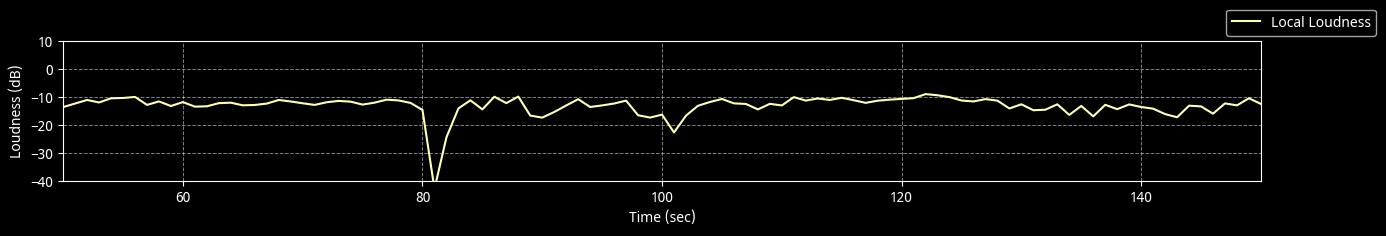

In [75]:
# Visualisation
fig = ms.fig("s", xlim=(50, 150))
fig.add_signal(loudness_contour, loudness_countour_t, label="Local Loudness", ylabel="Loudness (dB)", ylim=(-40, 10))
fig.add_xlabel("Time (sec)")
fig.add_legend()

# Tempo

In [8]:
# Utility functions
# Taken from FMP notebook

import scipy
from scipy.interpolate import interp1d
def resample_signal(y: np.ndarray, sr: float, target_sr: float) -> tuple[np.ndarray, float]:
	t_inp = np.arange(len(y)) * (1 / sr)
	dur_inp_sec = len(y) * (1 / sr)  # More accurate duration
	
	N_out = int(np.ceil(dur_inp_sec * target_sr))
	t_out = np.arange(N_out) * (1 / target_sr)
	
	if t_out[-1] > t_inp[-1]:
		t_inp = np.append(t_inp, t_out[-1])
		y = np.append(y, y[-1])  # use y[-1] or 0 depending on context
		
	interpolator = scipy.interpolate.interp1d(t_inp, y, kind="linear")
	y_resampled = interpolator(t_out)
	
	return y_resampled, target_sr

def get_spectrum_based_novelty(X: np.ndarray, X_sr: int, gamma: int | None = None, M: int | None = None, norm: bool | None = None) -> (np.ndarray, int):
	gamma = gamma or 10
	M = M or 40
	norm = norm or True
	
	def compute_local_average(x, M):
		L = len(x)
		local_average = np.zeros(L)
		for m in range(L):
			a = max(m - M, 0)
			b = min(m + M + 1, L)
			local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
		return local_average
	
	Y = np.log(1 + gamma * np.abs(X))
	Y_diff = np.diff(Y)
	Y_diff[Y_diff < 0] = 0
	novelty_spectrum = np.sum(Y_diff, axis=0)
	novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
	if M > 0:
		local_average = compute_local_average(novelty_spectrum, M)
		novelty_spectrum = novelty_spectrum - local_average
		novelty_spectrum[novelty_spectrum < 0] = 0.0
	if norm:
		max_value = max(novelty_spectrum)
		if max_value > 0:
			novelty_spectrum = novelty_spectrum / max_value
	return novelty_spectrum, X_sr

def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    # L = len(x)
    L_left = round(N / 2)
    L_right = L_left
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    A = np.zeros((N, M))
    win = np.ones(N)
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        x_local = win * x_pad[t_0:t_1]
        r_xx = np.correlate(x_local, x_local, mode='full')
        r_xx = r_xx[N-1:]
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        A[:, n] = r_xx
    Fs_A = Fs / H
    T_coef = np.arange(A.shape[1]) / Fs_A
    F_coef_lag = np.arange(N) / Fs
    return A, T_coef, F_coef_lag


def compute_tempogram_autocorr(nov, nov_sr, N, H, norm_sum=False, theta=np.arange(30, 601)):
    tempo_min = theta[0]
    tempo_max = theta[-1]
    lag_min = int(np.ceil(nov_sr * 60 / tempo_max))
    lag_max = int(np.ceil(nov_sr * 60 / tempo_min))
    A, T_coef, F_coef_lag = compute_autocorrelation_local(nov, nov_sr, N, H, norm_sum=norm_sum)
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    F_coef_BPM = theta
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(F_coef_BPM)
    return tempogram, T_coef, F_coef_BPM

In [31]:
def compute_tempo(y, sr):
    """
    Computes tempo of a song.

    Parameters
    ----------
    y: ndarray
        - Music signal to compute tempo of.
    sr: Number (> 0)
        - Sampling rate of the signal.

    Returns
    -------
    ndarray
        - Local tempo
    int
        - One aggregated tempo value for entire music 
    float
        - Confidence (0 to 1) of the aggregated tempo
    """
    # Step 1: Get the spectrogram
    N, H = 1024, 480 # ~21ms, 10ms
    S = librosa.stft(y=y, n_fft=N, win_length=N, hop_length=H, window="hann")
    S_sr = int(sr / H) # Frame rate
    
    # Step 2: Get novelty function
    nov, nov_sr = get_spectrum_based_novelty(X=S, X_sr=S_sr, gamma=10, M=40, norm=True)
    nov, nov_sr = resample_signal(y=nov, sr=nov_sr, target_sr=100) # Resampling it to 100 Hz
    
    # Step 3: Get tempogram
    T, T_frames, T_tempos = compute_tempogram_autocorr(nov=nov, nov_sr=nov_sr, N=4096, H=128, theta=np.arange(40, 600, 1))
    T = np.abs(T) # Magnitude
    T = T / np.max(T) # Normalisation
    threshold = 0.2
    T[T < 0.2] = 0
    
    # Step 4: Wrap octaves
    tempo_min, tempo_max = 80, 160
    wrapped_T_tempos = np.arange(tempo_min, tempo_max)
    wrapped_T = np.zeros((tempo_max - tempo_min, T.shape[1]), dtype=T.dtype)
    
    for i, tempo in enumerate(T_tempos):
        folded_tempo = tempo
        while folded_tempo >= tempo_max:
            folded_tempo /= 2
        while folded_tempo < tempo_min:
            folded_tempo *= 2
    
        if tempo_min <= folded_tempo < tempo_max:
            idx = np.argmin(np.abs(wrapped_T_tempos - folded_tempo))
            wrapped_T[idx, :] += T[i, :]
    
    # Step 5: Get local/frame-level tempo
    local_tempo = np.zeros(wrapped_T.shape[1])
    for i in range(wrapped_T.shape[1]):
        max_strength = np.max(wrapped_T[:,i]) # Max strength for a frame
        idx = np.argmax(wrapped_T[:,i])
        if max_strength < 0.4:
            local_tempo[i] = 0
        else:
            local_tempo[i] = wrapped_T_tempos[idx]
    
    # Step 6: Aggregate local tempo to get one tempo for entire song
    final_tempo, n_repeats = scipy.stats.mode(local_tempo[local_tempo>0])
    confidence = n_repeats / len(local_tempo[local_tempo>0])

    return local_tempo, T_frames, final_tempo, confidence

Tempo: 94 BPM 
Confidence: 1.00


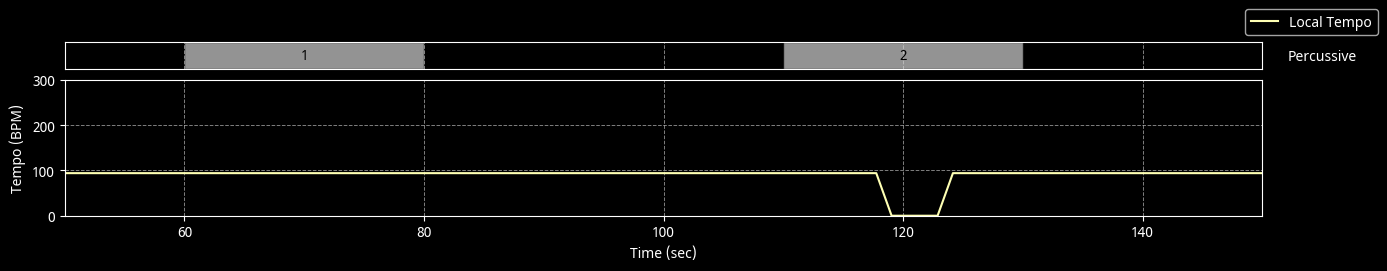

In [32]:
local_tempo, T_frames, final_tempo, confidence = compute_tempo(y, sr)
print(f"Tempo: {final_tempo:.0f} BPM \nConfidence: {confidence:.2f}")
fig = ms.fig("as", xlim=(50, 150))
fig.add_annotation(ann, label="Percussive")
fig.add_signal(local_tempo, T_frames, label="Local Tempo", ylabel="Tempo (BPM)", ylim=(0, 300))
fig.add_xlabel("Time (sec)")
fig.add_legend()

## Testing On A Dataset

In [ ]:
df = pd.read_csv("../../../data/srgm-music/label_data.csv")
for i, row in df.iterrows():
    filename = row['Filename']
    print(".", end="")
    audio_fp = "../../../data/srgm-music/" + filename
    y, sr, title = ms.load(audio_fp, sr=48000)
    _, _, computed_tempo, confidence = compute_tempo(y, sr)
    df.at[i, 'Computed Tempo (BPM)'] = computed_tempo
    df.at[i, 'Confidence (out of 1)'] = confidence

In [37]:
for i, row in df.iterrows():
    computed_tempo = row['Computed Tempo (BPM)']
    labelled_tempo = row['Tempo (BPM)']

    error_tempo = min(abs(computed_tempo - labelled_tempo), abs(computed_tempo // 2 - labelled_tempo), abs(2 * computed_tempo - labelled_tempo))
    df.at[i, 'Error (BPM)'] = error_tempo

In [61]:
df["Filename"] = "*******"
df.drop(columns=["PercussionStart (sec)", "AvailableLocally"])

,Filename,Tempo (BPM),Computed Tempo (BPM),Confidence (out of 1),Error (BPM)
0,*******,83,84.0,1.000000,1.0
1,*******,84,84.0,1.000000,0.0
2,*******,95,94.0,1.000000,1.0
3,*******,140,140.0,0.982609,0.0
4,*******,120,120.0,1.000000,0.0
5,*******,95,96.0,0.487603,1.0
6,*******,103,104.0,0.942308,1.0
7,*******,113,112.0,1.000000,1.0
8,*******,90,90.0,1.000000,0.0
9,*******,120,120.0,0.976744,0.0


# Spectral Roll-off Frequency

# Rhythmicity

**Rhythmicity** of a song refers to the degree to which the music exhibits a **clear**, **regular**, and **predictable** rhythmic structure. It involves how **consistently** and **strongly** the beats or pulses are felt throughout the piece.

## Factors Contribution to Rhythmicity

1. **Tempo regularity:** How steady the tempo is throughout the song.
2. **Accent structure:** The arrangement of strong and weak beat that gives rhythmic shape.
3. **Pattern Repetition:** How often the rhytmic patterns are repeated that establish predictablity.
4. **Pulse clarity:** How clear the beats are for listeners to tap to?

## Tempogram

In order to find out tempo dynamics, we need to estimate tempo locally. We do have a feature called **tempogram** that gives strength per frame for a given set of tempi. It is similar to a **spectrogram** except the frequency axis corresponds to tempo.

In [26]:
# Utility functions to compute tempogram [Ignore for now]
# Taken ƒrom FMP Notebook with some modification

def get_tempogram_fourier(nov: np.ndarray, nov_sr: int, N: int, H: int, theta=np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray):
	win = np.hanning(N)
	N_left = N // 2
	L = nov.shape[0]
	L_left = N_left
	L_right = N_left
	L_pad = L + L_left + L_right
	# x_pad = np.pad(x, (L_left, L_right), 'constant')  # doesn't work with jit
	x_pad = np.concatenate((np.zeros(L_left), nov, np.zeros(L_right)))
	t_pad = np.arange(L_pad)
	M = int(np.floor(L_pad - N) / H) + 1
	K = len(theta)
	X = np.zeros((K, M), dtype=np.complex128)
	
	for k in range(K):
		omega = (theta[k] / 60) / nov_sr
		exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
		x_exp = x_pad * exponential
		for n in range(M):
			t_0 = n * H
			t_1 = t_0 + N
			X[k, n] = np.sum(win * x_exp[t_0:t_1])
		T_coef = np.arange(M) * H / nov_sr
		F_coef_BPM = theta
		
	return X, T_coef, F_coef_BPM

def get_tempogram_autocorr(nov, nov_sr, N, H, norm_sum=False, theta=np.arange(30, 601)):
    tempo_min = theta[0]
    tempo_max = theta[-1]
    lag_min = int(np.ceil(nov_sr * 60 / tempo_max))
    lag_max = int(np.ceil(nov_sr * 60 / tempo_min))
    A, T_coef, F_coef_lag = compute_autocorrelation_local(nov, nov_sr, N, H, norm_sum=norm_sum)
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    F_coef_BPM = theta
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(F_coef_BPM)
    return tempogram, T_coef, F_coef_BPM

In [27]:
# Step 1
nov, nov_sr = get_spectrum_based_novelty(X=S, X_sr=S_sr, gamma=10, M=40, norm=True)

# Step 2
nov, nov_sr = resample_signal(y=nov, sr=nov_sr, target_sr=100)

# Step 3
T, T_frames, T_tempos = get_tempogram_fourier(nov=nov, nov_sr=nov_sr, N=2048, H=128, theta=np.arange(40, 600, 1))
T_sr = nov_sr / 128
T = np.abs(T) # Magnitude
T = T / np.max(T) # Normalisation

# Dropping values < threshold
threshold = 0.2
T[T < threshold] = 0.0

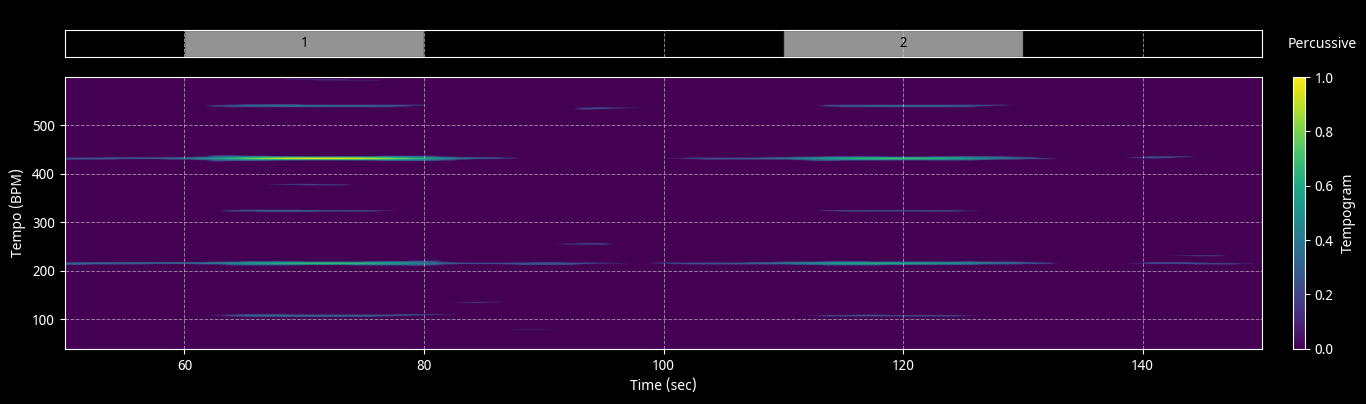

In [31]:
fig = ms.fig("am", xlim=(50, 150))
fig.add_annotation(ann, label="Percussive")
fig.add_matrix(np.abs(T), T_tempos, T_frames, o="lower", label="Tempogram", ylabel="Tempo (BPM)")
fig.add_xlabel("Time (sec)")

Now we will compute the strength per frame by aggregating tempo strength for each frame.

In [32]:
percussive_activity = np.zeros(T.shape[1])
for frame in range(T.shape[1]):
    percussive_activity[frame] = np.sum(T[:,frame])
percussive_activity /= np.max(percussive_activity) # Max norm (Range: 0 to 1)

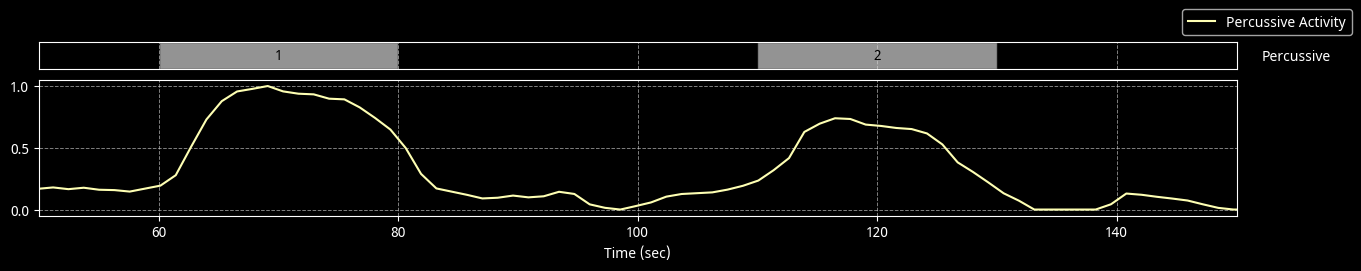

In [77]:
fig = ms.fig("as", xlim=(50, 150))
fig.add_annotation(ann, label="Percussive")
fig.add_signal(percussive_activity, np.arange(percussive_activity.size) / T_sr, label="Percussive Activity")
fig.add_xlabel("Time (sec)")
fig.add_legend()